# Chest X-ray image classification and Pneumonia detection

In [1]:
%config Completer.use_jedi=False
%matplotlib inline

## Importing libraries

In [2]:
import time
import copy
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cpu


## Loading the data

In [5]:
train_normal = glob.glob("archive/chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("archive/chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("archive/chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("archive/chest_xray/test/PNEUMONIA/*")

In [6]:
train_paths = train_normal+train_pneumonia
test_paths = test_normal+test_pneumonia

In [7]:
#this is to label 0 for normal and 1 for pneumonia
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

In [8]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

5216 5216
624 624


In [9]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, stratify = train_labels)

In [10]:
#investigate and test data
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)
    fig = plt.figure(figsize = (10,10))
    axl = plt.subplot(1,2,1)
    axl.imshow(Image.open(path_random_normal).convert("LA"))
    axl.set_title("Normal X-ray")
    ax2 = plt.subplot(1,2,2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")

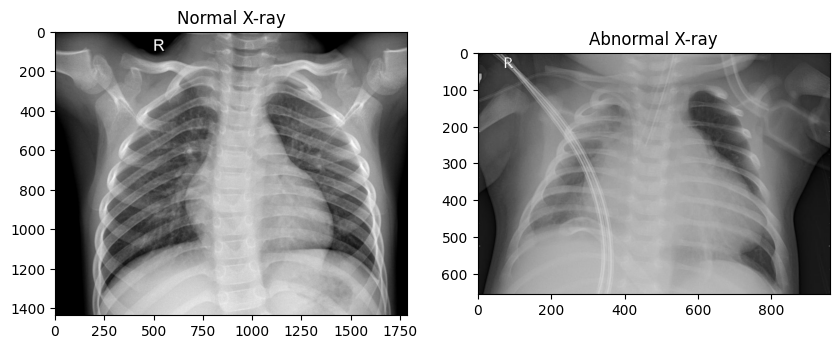

In [11]:
show_random_images()

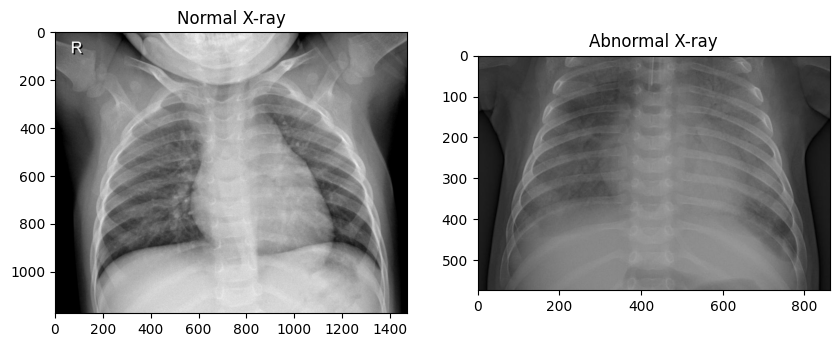

In [12]:
show_random_images()

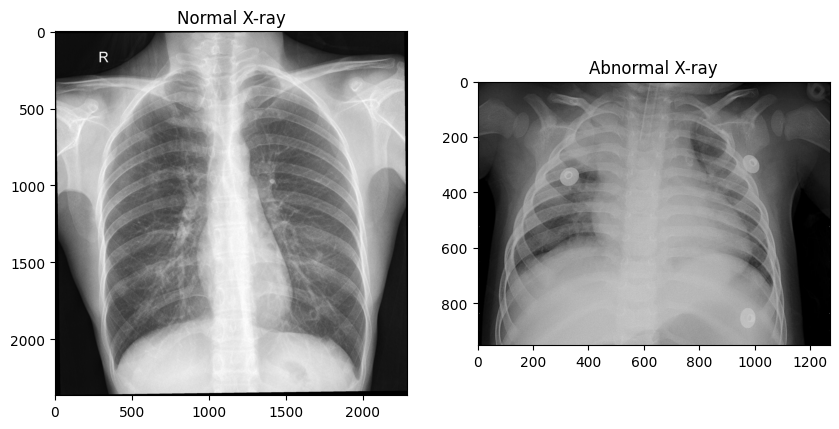

In [13]:
show_random_images()

In [14]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform = None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[index]
        label = torch.tensor([label])
        
        return image, label

In [15]:
train_dataset = XrayDataset(train_paths, train_labels)

In [16]:
len(train_dataset)

3912

In [17]:
resent = resnet18()

In [18]:
# CNN layers
resent

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
class PneumoniaNet(nn.Module):
    def __init__(self, pretrained = True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained = pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1)
        
    def forward(self, x):
        #layer 0
        x = self.backbone.convl(x)
        x = self.backbone.bnl(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        #other layers
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        
        x = x.view(x.size(0), 512)
        x = self.fc(x)
        
        return x

In [20]:
image_size = (500, 500)  #resizing the images so that it increases the speed

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees = 15),
    transforms.Resize(size = image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [23]:
pretrained = True

model = PneumoniaNet(pretrained = pretrained)

lr = 3e-3

num_epochs = 5
train_batch_size = 16
valid_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)

dataloaders = {
    'train': train_dataloader,
    'val': valid_dataloader
}

logging_steps = {
    'train': len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

dataset_size = {
    'train': len(train_dataset),
    'val': len(valid_dataset)
}

batch_size = {
    'train': train_batch_size,
    'val': valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr = lr)

In [27]:
#training pipeline of the model
from tqdm import tqdm
def train_model(model, criterion, optimizer, num_epochs, device = 'cpu'):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in tqdm(range(num_epochs), leave = False):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), leave = False, total = len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if (i%logging_steps[phase] == 0) & (i>0):
                    avg_loss = running_loss / ((i+1)*batch_sizes[phase])
                    avg_acc = running_corrects / ((i+1)*batch_sizes[phase])
                    
                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss: {avg_loss} | acc: {avg_acc}")
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    
    print(f"training took {time_elapsed} seconds")
    
    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
model = train_model(model, criterion, optimizer, num_epochs)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

In [ ]:
test_path = glob.glob("archive/chest_xray/test/NORMAL/*") + glob.glob("archive/chet_xray/test/PNEUMONIA/*")
test_labels = [0]*len(glob.glob("archive/chest_xray/test/NORMAL/*")) + [1]*len(glob.glob("archive/chet_xray/test/PNEUMONIA/*"))

In [ ]:
len(test_path), len(test_labels)

In [ ]:
test_dataset = XrayDataset(test_path, test_paths, test_transform)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False, drop_last = False)

In [ ]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave = False, total = len(test_dataloader)):
    with torch.no_grad():
        predictions = model(tensors.cuda())
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5
        y_pred.append(predictions)
        y_true.append(labels)

In [ ]:
y_pred[0]

In [ ]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [ ]:
y_pred.shape, y_true.shape

In [ ]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [ ]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [ ]:
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [ ]:
y_pred.shape, y_true.shape

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)